# Part 0

In [4]:
# --- Part 0: Import libraries and load dataset ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Mount Google Drive (for Google Colab users)
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
data_path = "/content/drive/MyDrive/EFIplus_medit.csv"
df = pd.read_csv(data_path, sep=';')

# Clean column names
df.columns = df.columns.str.strip().str.lower()
print(f"✅ Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded with 5011 rows and 164 columns.


# Part 1

In [5]:
# --- Part 1: Filter target catchments and select quantitative environmental variables ---

# Filter for Douro, Tejo, Mondego, and Minho basins
basins = ['Douro', 'Tejo', 'Mondego', 'Minho']
df_sel = df[df['catchment_name'].isin(basins)].copy()

# Define environmental variables
envi_vars = ['altitude', 'actual_river_slope', 'elevation_mean_catch',
             'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']

# Subset and drop missing values
df_env = df_sel[['catchment_name'] + envi_vars].dropna()

# Normalize variables
scaler = StandardScaler()
X = scaler.fit_transform(df_env[envi_vars])

# Store groups
groups = df_env['catchment_name'].values


# Part 2

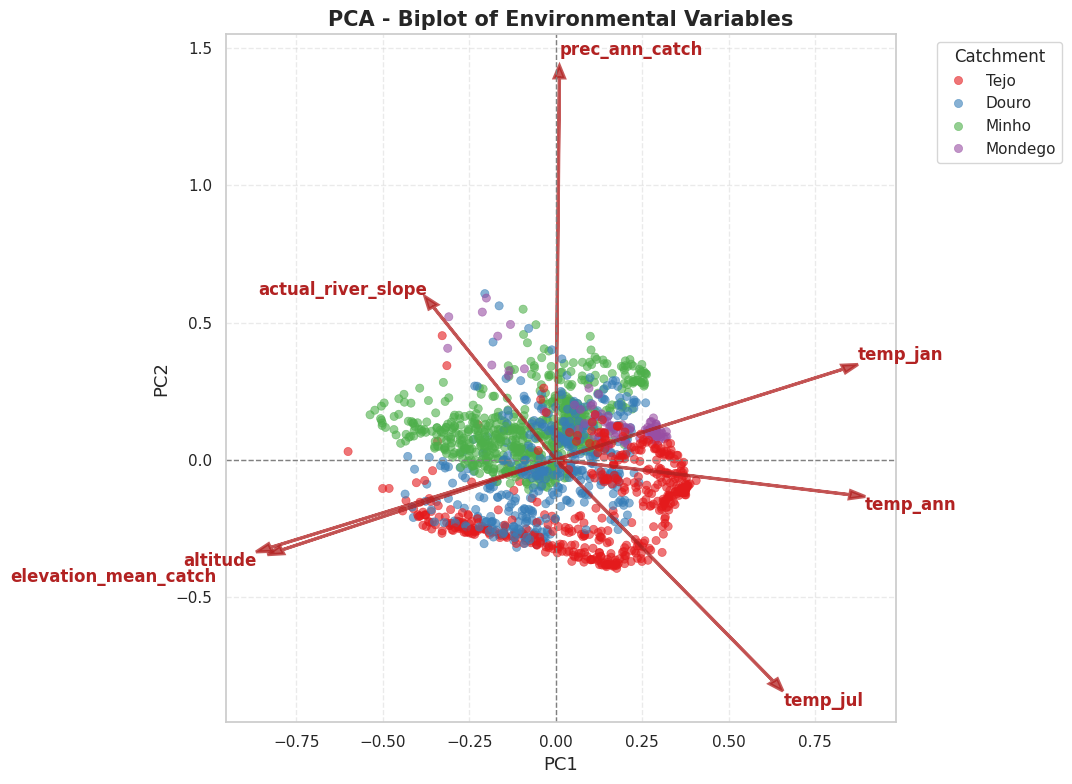

In [15]:
# --- Part 2: PCA and biplot ---

# Run PCA
pca = PCA(n_components=2)
PC = pca.fit_transform(X)

# Final refined biplot function
def pca_biplot(score, coeff, hue, labels=None):
    sns.set(style="whitegrid")

    # Normalize PCA scores
    xs, ys = score[:, 0], score[:, 1]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    xs_jitter = xs * scalex + np.random.normal(0, 0.005, size=len(xs))
    ys_jitter = ys * scaley + np.random.normal(0, 0.005, size=len(ys))

    # Scatter plot
    plt.figure(figsize=(11, 8))
    sns.scatterplot(
        x=xs_jitter, y=ys_jitter, hue=hue,
        s=35, alpha=0.6, palette="Set1", edgecolor=None
    )

    # Arrows and labels
    for i in range(coeff.shape[0]):
        arrow_x = coeff[i, 0] * 1.8
        arrow_y = coeff[i, 1] * 1.8

        # Draw arrow
        plt.arrow(
            0, 0, arrow_x, arrow_y,
            color='firebrick', alpha=0.75, linewidth=2.2, head_width=0.03
        )

        # Default label position
        label_x = arrow_x * 1.05
        label_y = arrow_y * 1.05
        ha = 'left' if arrow_x >= 0 else 'right'
        va = 'bottom' if arrow_y >= 0 else 'top'

        # Manual adjustment for elevation_mean_catch
        if labels[i] == 'elevation_mean_catch':
            label_x -= 0.15
            label_y -= 0.05
            ha = 'right'
            va = 'top'

        # Draw label
        plt.text(
            label_x, label_y, labels[i],
            color='firebrick', fontsize=12, fontweight='bold',
            ha=ha, va=va
        )

    # Formatting
    plt.xlabel("PC1", fontsize=13)
    plt.ylabel("PC2", fontsize=13)
    plt.title("PCA - Biplot of Environmental Variables", fontsize=15, weight='bold')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title='Catchment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run the biplot
pca_biplot(PC, pca.components_.T, hue=groups, labels=envi_vars)




# Part 3

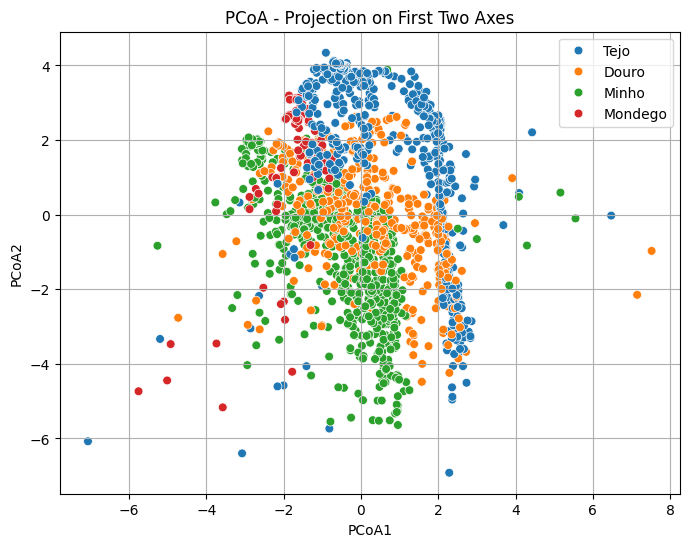

In [7]:
# --- Part 3: PCoA (classical MDS with Euclidean distance) ---

# Distance matrix
dist_matrix = pairwise_distances(X, metric='euclidean')

# Apply MDS for PCoA
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
PCoA = mds.fit_transform(dist_matrix)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=PCoA[:, 0], y=PCoA[:, 1], hue=groups, s=40)
plt.xlabel("PCoA1")
plt.ylabel("PCoA2")
plt.title("PCoA - Projection on First Two Axes")
plt.grid(True)
plt.show()


# Part 4

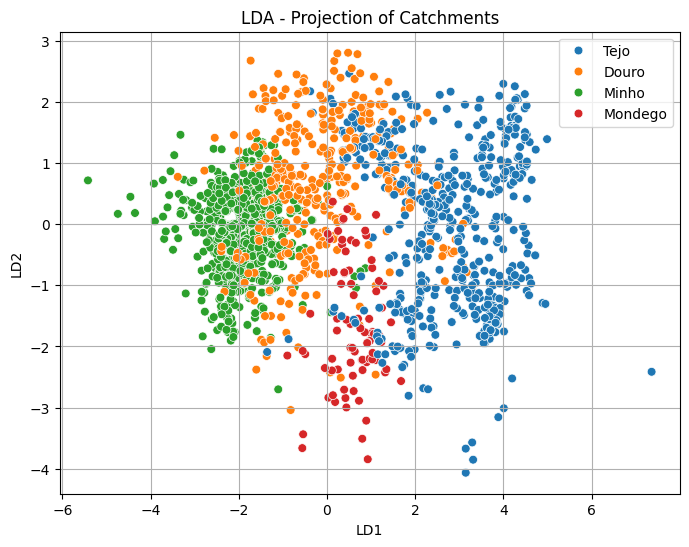

In [8]:
# --- Part 4: LDA and biplot ---

lda = LDA(n_components=2)
LDA_proj = lda.fit_transform(X, groups)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=LDA_proj[:, 0], y=LDA_proj[:, 1], hue=groups, s=40)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA - Projection of Catchments")
plt.grid(True)
plt.show()
